In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
#from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict


RSEED=42

In [3]:
df = pd.read_csv('data_text_processed.csv')

In [4]:
df[['launched_at_day','launched_at_month']]=df[['launched_at_day','launched_at_month']].astype(object)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177522 entries, 0 to 177521
Columns: 114 entries, blurb to young
dtypes: float64(101), int64(4), object(9)
memory usage: 154.4+ MB


In [5]:
df['target'] = df['state'].apply(lambda x: 1 if x == 'successful' else 0)

In [6]:
df.drop(['state', 'blurb', 'name'], axis=1, inplace=True)

In [7]:
X = df.drop(['target'], axis=1)
y = df['target']
print(f"We have {X.shape[0]} observations in our dataset and {X.shape[1]} features")
print(f"Our target vector has also {y.shape[0]} values")

We have 177522 observations in our dataset and 110 features
Our target vector has also 177522 values


In [8]:
# get percentage of class imbalance
print(f"Percentage of successful projects: {round(y.value_counts()[1]/len(y),2)*100}%")
print(f"Percentage of failed projects: {round(y.value_counts()[0]/len(y),2)*100}%")
# print ratio of class imbalance
print(f"Ratio of successful projects to failed projects: {round(y.value_counts()[1]/y.value_counts()[0],2)}")


Percentage of successful projects: 53.0%
Percentage of failed projects: 47.0%
Ratio of successful projects to failed projects: 1.14


In [9]:
# Creating list for categorical predictors/features 
# (dates are also objects so if you have them in your data you would deal with them first)
cat_features = list(X.columns[X.dtypes==object])
cat_features

['country',
 'main_category',
 'sub_category',
 'location_type',
 'launched_at_month',
 'launched_at_day']

In [10]:
# Creating list for numerical predictors/features
# Since 'Survived' is our target variable we will exclude this feature from this list of numerical predictors 
num_features = list(X.columns[X.dtypes!=object])

In [11]:
# Split into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RSEED)

In [12]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (142017, 110)
X_test shape: (35505, 110)
y_train shape: (142017,)
y_test shape: (35505,)


In [13]:
X.describe()
X['goal'] = np.log(X['goal'])

In [14]:
from sklearn.pipeline import Pipeline

# Pipeline for numerical features
# Initiating Pipeline and calling one step after another
# each step is built as a list of (key, value)
# key is the name of the processing step
# value is an estimator object (processing step)
num_pipeline = Pipeline([
    ('imputer_num', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

# Pipeline for categorical features 
cat_pipeline = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

In [15]:
from sklearn.compose import ColumnTransformer

# Complete pipeline for numerical and categorical features
# 'ColumnTransformer' applies transformers (num_pipeline/ cat_pipeline)
# to specific columns of an array or DataFrame (num_features/cat_features)
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

In [16]:
# Building a full pipeline with our preprocessor and a LogisticRegression Classifier
pipe_logreg = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(max_iter=1000))
])

In [17]:
# Making predictions on the training set using cross validation as well as calculating the probabilities
# cross_val_predict expects an estimator (model), X, y and nr of cv-splits (cv)
y_train_predicted = cross_val_predict(pipe_logreg, X_train, y_train, cv=5)
y_test_predicted = cross_val_predict(pipe_logreg, X_test, y_test, cv=5)

In [18]:
# Calculating the accuracy for the LogisticRegression Classifier 
print('Cross validation scores:')
print('-------------------------')
print("Accuracy: {:.4f}".format(accuracy_score(y_train, y_train_predicted)))
print("Recall: {:.4f}".format(recall_score(y_train, y_train_predicted)))
print("Precision: {:.4f}".format(precision_score(y_train, y_train_predicted)))
print(confusion_matrix(y_train, y_train_predicted))

print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_test_predicted)))
print("Recall: {:.4f}".format(recall_score(y_test, y_test_predicted)))
print("Precision: {:.4f}".format(precision_score(y_test, y_test_predicted)))
print(confusion_matrix(y_test, y_test_predicted))


Cross validation scores:
-------------------------
Accuracy: 0.7676
Recall: 0.7217
Precision: 0.8201
[[54462 11967]
 [21034 54554]]
Accuracy: 0.7653
Recall: 0.7255
Precision: 0.8116
[[13525  3169]
 [ 5163 13648]]


In [19]:
# f1 score
f1_score(y_test, y_test_predicted)

0.7661389918041989

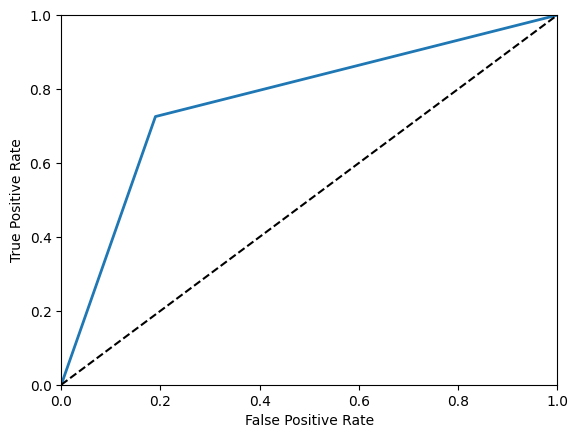

In [20]:
# plot roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_predicted)
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], 'k--')
plt.axis([0,1,0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


In [21]:
# classification report
print(classification_report(y_test, y_test_predicted))


              precision    recall  f1-score   support

           0       0.72      0.81      0.76     16694
           1       0.81      0.73      0.77     18811

    accuracy                           0.77     35505
   macro avg       0.77      0.77      0.77     35505
weighted avg       0.77      0.77      0.77     35505



In [22]:
# f1-beta score
from sklearn.metrics import fbeta_score
print(fbeta_score(y_test, y_test_predicted, beta=1.2))

0.7584840304622451


In [23]:
# Defining parameter space for grid-search. Since we want to access the classifier step (called 'logreg') in our pipeline 
# we have to add 'logreg__' in front of the corresponding hyperparameters. 
param_logreg = {'logreg__penalty':('l1','l2'),
                'logreg__C': [0.001, 0.01, 0.1, 1, 10],
                'logreg__solver': ['liblinear', 'lbfgs', 'sag']
               }

# grid_logreg = GridSearchCV(pipe_logreg, param_grid=param_logreg, cv=5, scoring='recall', 
#                            verbose=5, n_jobs=-1)

In [24]:
# grid_logreg.fit(X_train, y_train)

In [25]:
# Show best parameters
# print('Best score:\n{:.2f}'.format(grid_logreg.best_score_))
# print("Best parameters:\n{}".format(grid_logreg.best_params_))


In [26]:
# Save best model (including fitted preprocessing steps) as best_model 
# best_model = grid_logreg.best_estimator_
# best_model

In [27]:
#Calculating the accuracy, recall and precision for the test set with the optimized model
# y_test_predicted = best_model.predict(X_test)
# y_train_predicted = best_model.predict(X_train)

# print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predicted)))
# print("Recall: {:.2f}".format(recall_score(y_test, y_test_predicted)))
# print("Precision: {:.2f}".format(precision_score(y_test, y_test_predicted)))
# print(confusion_matrix(y_test, y_test_predicted))

# print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_predicted)))
# print("Recall: {:.2f}".format(recall_score(y_train, y_train_predicted)))
# print("Precision: {:.2f}".format(precision_score(y_train, y_train_predicted)))
# print(confusion_matrix(y_train, y_train_predicted))